## Load Data

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

## Visualize a few images

In [ ]:
# Technique de transformation d'augmentation de données pour la robustesse du modèle.
data_transforms = {
    'train': transforms.Compose([ #On combine les transformations pour les données d'entrainement.
        transforms.RandomResizedCrop(224), # On recadre l'image et on redimensionne à 224x224 pixels
        transforms.RandomHorizontalFlip(), # On retourne l'image horizontalement avec proba 1/2.
        transforms.ToTensor(), # On transforme l'image en tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # On normalise l'image pour chaques couleurs
        # Le rouge avec moyenne 0.485 et écart-type 0.229
        # Le vert avec moyenne 0.456 et écart-type 0.224
        # Le bleu avec moyenne 0.406 et écart-type 0.225
    ]),
    'val': transforms.Compose([ #On combine les transformations pour les données de validation.
        transforms.Resize(256), # On redimensionne l'image à max 256x256 pixels
        transforms.CenterCrop(224), # On coupe au centre l'image un carré de taille 224x224
        transforms.ToTensor(), # On transforme l'image en tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # On normalise l'image pour chaques couleurs
        # Le rouge avec moyenne 0.485 et écart-type 0.229
        # Le vert avec moyenne 0.456 et écart-type 0.224
        # Le bleu avec moyenne 0.406 et écart-type 0.225
    ]),
}

data_dir = '/content/drive/MyDrive/hymenoptera_data' # Chemin d'accès
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), #On charge le jeu de données
                                          data_transforms[x]) #On applique les transformations sur les images
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, #On charge les images en lot de 4
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes # On liste le nom des classes.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


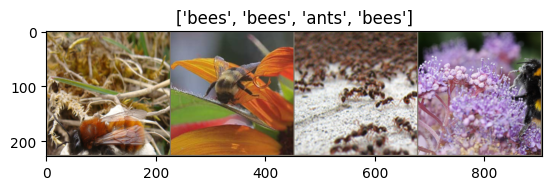

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) #On convertit l'affichage pour le rendre compatible avec Matplotlib
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # On annule la normalisation des images
    inp = np.clip(inp, 0, 1) #On limite la valeur des picels entre [0,1]
    plt.imshow(inp) #On affiche l'image
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


inputs, classes = next(iter(dataloaders['train'])) #On récupère un lot d'image

out = torchvision.utils.make_grid(inputs) #On construit une grille à partir du lot

imshow(out, title=[class_names[x] for x in classes]) # On affiche la grille d'iamges avec les classes correspondantes

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()
  """
  :param model: le modèle à entraîner
  :param criterion: la fonction de perte
  :param optimizer: l'optimiseur utilisé
  :param scheduler: le scheduler qui ajuste le taux d'apprentissage pendant l'entrainement
  :param num_epochs: le nombre d'époques
  :return: le modèle entraîné
  """


  # On crée un fichier temporaire pour sauvegarder  les paramètres du modèle pendant l'entrainement
  with TemporaryDirectory() as tempdir:
      best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

      torch.save(model.state_dict(), best_model_params_path) #Poids initiaux du modèle
      best_acc = 0.0

      for epoch in range(num_epochs):
          print(f'Epoch {epoch}/{num_epochs - 1}')
          print('-' * 10)

          # Each epoch has a training and validation phase
          for phase in ['train', 'val']:
              if phase == 'train':
                  model.train()  # On place le modèle en mode entrainement
              else:
                  model.eval()   # On place le modèle en mode évaluation

              running_loss = 0.0
              running_corrects = 0

              # Iterate over data.
              for inputs, labels in dataloaders[phase]:
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  optimizer.zero_grad() # On met les gradients à 0

                  # forward pass lorsque le modèle est en mode enrainement
                  # On fait passer les inputs à travers le modèle
                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs)
                      _, preds = torch.max(outputs, 1)
                      loss = criterion(outputs, labels)

                      # backward pass
                      # On réduit la fonction de perte à l'aide d'une descente de gradient
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()

                  # statistics
                  running_loss += loss.item() * inputs.size(0) # on accumule la perte pour l'epoch actuelle
                  running_corrects += torch.sum(preds == labels.data) #On compte le nombre de prédictions vraies
              if phase == 'train':
                  scheduler.step() # On met à jour le scheduler d'apprentissage

              epoch_loss = running_loss / dataset_sizes[phase] # Calcul de la perte moyenne de l'epoch actuelle
              epoch_acc = running_corrects.double() / dataset_sizes[phase] # Calcul de la précision moyenne de l'epoch actuelle

              print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

              # Copie profonde du modèle
              if phase == 'val' and epoch_acc > best_acc:
                  best_acc = epoch_acc
                  torch.save(model.state_dict(), best_model_params_path)

          print()

      time_elapsed = time.time() - since
      print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
      print(f'Best val Acc: {best_acc:4f}')

      # load best model weights
      model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
  return model

In [ ]:
def visualize_model(model, num_images=6):
  """
  Affiche les prédictions du modèle sur un lot d'images.
  :param model: le modèle à entraîner
  :param num_images: le nombre d'images à afficher
  :return: None
  """
  was_training = model.training #On garde l'état initial du modèle pour le restaurer plus tard
  model.eval() #On passe le modèle en mode évaluation
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad(): # On désactive le calcul de gradient
      for i, (inputs, labels) in enumerate(dataloaders['val']):
          # On déplace les données d'entrées et les labels dans le cpu ou gpu
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs) #On passe les images à travers le modèle
          _, preds = torch.max(outputs, 1) #

          #On affiche chaque image avec les prédictions du modèle
          for j in range(inputs.size()[0]):
              images_so_far += 1
              ax = plt.subplot(num_images//2, 2, images_so_far)
              ax.axis('off')
              ax.set_title(f'predicted: {class_names[preds[j]]}')
              imshow(inputs.cpu().data[j])

              if images_so_far == num_images:
                  model.train(mode=was_training) # On remet le modèle à son état initial
                  return

      model.train(mode=was_training) # On remet le modèle à son état initial

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
#On remplace la dernière couche du modèle
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss() # Définition de la fonction de perte

# Optimiseur de descente de gradient stochastique
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Le scheduler diminue le taux d'apprentissage par un facteur gamme = 0.1 toutes les 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


In [ ]:
#On entraine le modèle sur 25 epochs
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5695 Acc: 0.7323
val Loss: 0.4029 Acc: 0.8235

Epoch 1/24
----------
train Loss: 0.4074 Acc: 0.8386
val Loss: 0.3487 Acc: 0.8562

Epoch 2/24
----------
train Loss: 0.5927 Acc: 0.7913
val Loss: 0.3070 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.4406 Acc: 0.8071
val Loss: 0.6519 Acc: 0.8039

Epoch 4/24
----------
train Loss: 0.4477 Acc: 0.8228
val Loss: 0.3506 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4388 Acc: 0.8543
val Loss: 0.4219 Acc: 0.8497

Epoch 6/24
----------
train Loss: 0.4227 Acc: 0.7953
val Loss: 0.3065 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.3987 Acc: 0.8268
val Loss: 0.2256 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3012 Acc: 0.8661
val Loss: 0.2076 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2915 Acc: 0.8701
val Loss: 0.2247 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3012 Acc: 0.8858
val Loss: 0.1872 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3571 Acc: 0.8622
val Loss: 0.1982 Acc: 0.9281

Ep

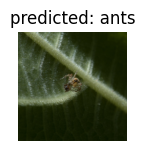

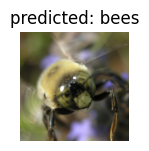

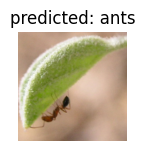

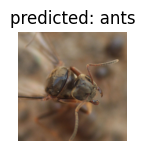

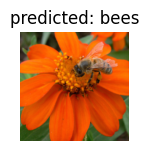

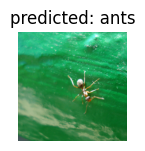

In [ ]:
visualize_model(model_ft) #On affiche les images avec leurs prédictions

## ConvNet as fixed feature extractor

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
#On remplace la dernière couche du modèle
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device) # On déplace model_conv sur le cpu ou le gpu

criterion = nn.CrossEntropyLoss() # Fonction de perte

#On optimise seulement les paramètres de la dernière couche de neurone
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Le scheduler diminue le taux d'apprentissage par un facteur gamme = 0.1 toutes les 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
#On entraine le modèle sur 25 epochs
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5559 Acc: 0.6575
val Loss: 0.1942 Acc: 0.9608

Epoch 1/24
----------
train Loss: 0.4537 Acc: 0.7677
val Loss: 0.2401 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4456 Acc: 0.8150
val Loss: 0.1627 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.4630 Acc: 0.7953
val Loss: 0.2717 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.3967 Acc: 0.8386
val Loss: 0.2367 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.4364 Acc: 0.7874
val Loss: 0.1751 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.5164 Acc: 0.8110
val Loss: 0.2509 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3764 Acc: 0.8661
val Loss: 0.2079 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3469 Acc: 0.8583
val Loss: 0.1839 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3027 Acc: 0.8622
val Loss: 0.1902 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3372 Acc: 0.8543
val Loss: 0.1774 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.2877 Acc: 0.8898
val Loss: 0.1720 Acc: 0.9412

Ep

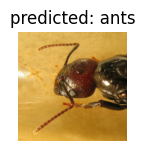

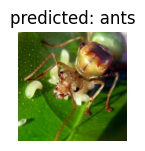

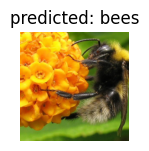

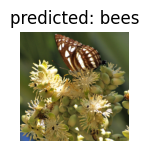

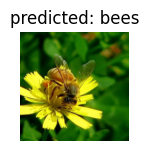

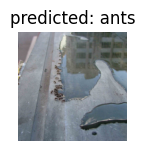

In [ ]:
visualize_model(model_conv) #On affiche les images avec leurs prédictions

plt.ioff()
plt.show()

## Inference on custom images

In [ ]:
def visualize_model_predictions(model,img_path):
    """
    Affiche les prédictions du modèle sur une image personnalisée.
    :param model: le modèle à entraîner
    :param img_path: le chemin de l'image personnalisée
    :return: None
    """
    was_training = model.training #On garde l'état initial du modèle pour le restaurer plus tard
    model.eval() #On passe le modèle en mode évaluation

    img = Image.open(img_path) #On charge l'image personnalisée
    img = data_transforms['val'](img) #On applique les transformation de 'val' sur l'image
    img = img.unsqueeze(0) # On simule un lot de taille 1
    img = img.to(device) # on séplace l'image sur le même dispositif que le modèle (cpu ou gpu)

    with torch.no_grad(): # Pas de calcul de gradient pour économiser du temps
        outputs = model(img) # On apsse l'image à travers le modèle
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training) # On remet le modèle à l'état initial

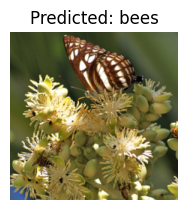

In [ ]:
visualize_model_predictions( #On affiche les images avec leurs prédictions
    model_conv,
    img_path='/content/drive/MyDrive/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()